In [1]:
# TO-DO
# 0) look at data, determine scale of imbalance
# 1) data-reading
# 2) implement k-means treatment
# 3) forest stuff
#
#...
#
# X) understand why self-outcome isn't in top neighbors



In [ ]:
#sources:
#    https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
#    pandas user manual
#    https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
df_raw = pd.read_csv('/home/btannenw/Desktop/life/challenges/BRAF/ML_Technical/diabetes.csv')

In [6]:
df_raw
df_dropZero = df_raw[ df_raw.Insulin!=0]
df_minMaxScale = minMaxScaleVariables(df_dropZero)
df_standardScale = standardScaleVariables(df_dropZero)

Pregnancies 0 17
Glucose 0 198
BloodPressure 24 110
SkinThickness 7 63
Insulin 14 846
BMI 0.0 67.1
DiabetesPedigreeFunction 0.085 2.42
Age 21 81
Pregnancies 3.286802030456853 3.2055596415650096
Glucose 122.30456852791878 31.356855959690474
BloodPressure 70.65482233502539 12.45408377334157
SkinThickness 29.106598984771573 10.490934307595936
Insulin 155.5482233502538 118.62502864362725
BMI 32.98857868020305 7.201004337041017
DiabetesPedigreeFunction 0.5255431472081219 0.34968234231099693
Age 30.814720812182742 10.186020406620273


In [5]:
def plotOneVariable(_df, varName='', bins=10):
    """ just like what it sounds like"""
    
    plt.hist( _df[varName], bins=bins)
    plt.xlabel(varName)
    plt.show()
    
    return

def calculateCorrelation(_df, varName1='', varName2='', threshold=0.0):
    """ calculate correlation between two variables"""
    
    r = np.corrcoef( _df[varName1], _df[varName2])
    #print(r)
    p = r[0,1]
    
    if np.abs(p) > threshold:
        print("Pearson R ({},{}) = {:.3f}".format(varName1, varName2, r[0,1]))
    
    return

def minMaxScaleVariables(df):
    """return dataframe with variables scaled to [0,1] """
    _df = df.copy()
    
    for variable in _df.columns.to_list():
        if variable == 'Outcome':
            continue
            
        minVal = np.min(_df[variable])
        maxVal = np.max(_df[variable])
        print(variable, minVal, maxVal)
        _df[variable] = _df[variable].apply(lambda x: (x-minVal)/maxVal)
        
    return _df

def standardScaleVariables(df):
    """return dataframe with variables scaled to [0,1] """
    _df = df.copy()
    
    for variable in _df.columns.to_list():
        if variable == 'Outcome':
            continue
            
        meanVal = np.mean(_df[variable])
        stdVal = np.std(_df[variable])
        print(variable, meanVal, stdVal)
        _df[variable] = _df[variable].apply(lambda x: (x-meanVal)/stdVal)
        
    return _df


In [6]:
def returnTestTrainSplit(_df, testingFraction=0.2):
    """takes in dataset, returns testing and training sets split by outcome"""
    
    # Outcome == 1
    _df_outcome1 = _df[_df.Outcome == 1]
    _trainLength = int((1-testingFraction)*len(_df_outcome1))
    
    _train_outcome1 = _df_outcome1[:_trainLength]
    _test_outcome1  = _df_outcome1[_trainLength:]
    print(len(_df_outcome1), _trainLength, len(_train_outcome1), len(_test_outcome1))

    # Outcome == 0
    _df_outcome0 = _df[_df.Outcome == 0]
    _trainLength = int((1-testingFraction)*len(_df_outcome0))
    
    _train_outcome0 = _df_outcome0[:_trainLength]
    _test_outcome0  = _df_outcome0[_trainLength:]
    print(len(_df_outcome0), _trainLength, len(_train_outcome0), len(_test_outcome0))

    return _train_outcome1, _test_outcome1, _train_outcome0, _test_outcome0

def returnDistance(testRow, seedRow):
    """ calculate distance and return"""
    
    distance = 0
    
    for variable in testRow.keys().to_list():
        distance += (testRow[variable]-seedRow[variable])**2
    
    return np.sqrt(distance)

def applyNeighborDistance(seedRow, df):
    """add column of distance to original point"""
    _df = df.copy()
    
    _df['neighborDistance'] = _df.apply( lambda x: returnDistance(x, seedRow), axis=1)
    
    return _df
    

def buildCriticalSet( _train0, _train1, k=5):
    """ build critical set using k-nearest neighbor algorithm"""
    
    _Tc = _train1.copy()
    _T = _train0.copy()
    _T = _T.append(_train1.copy())
    
    for iRow in range(0, len(_T)):
        if _T.iloc[iRow].Outcome == 1:
            # calculate distance for selected rows and apply as new column
            _tempT = applyNeighborDistance( _T.iloc[iRow], _T)
            # keep the top 6 (includes self + top5)
            _tempTop6 = _tempT.nsmallest(k+1, 'neighborDistance')
            _tempTop6 = _tempTop6.drop(columns=['neighborDistance'])
            #print(iRow, _tempTop6)
            
            # add top to critical set
            _Tc = _Tc.append(_tempTop6)
            
            # drop duplicates
            _Tc.drop_duplicates(keep='first', inplace=True)

    return _Tc

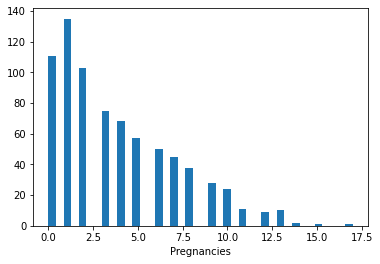

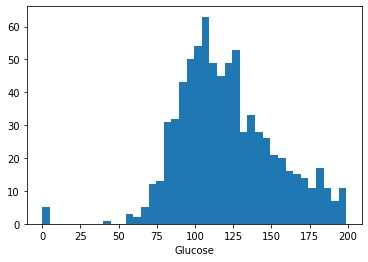

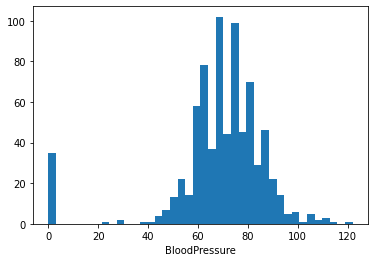

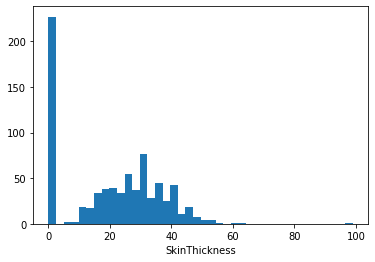

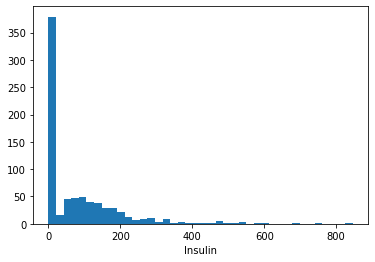

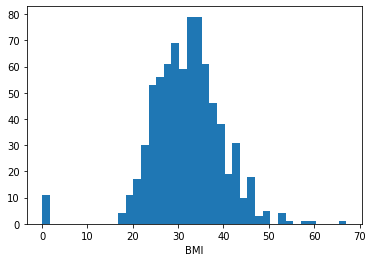

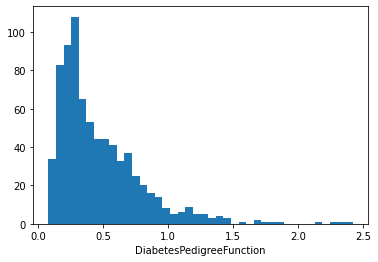

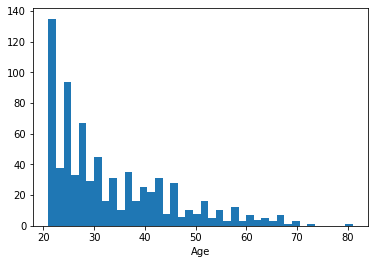

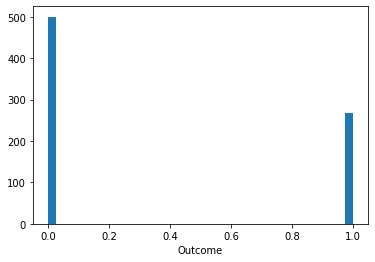

In [8]:
nBins = 40
#plotVar = 'Insulin'
plotVar = 'SkinThickness'

for variable in df_dropZero.columns.to_list():
    plotOneVariable(df_raw, variable, bins=nBins)
    
    #if variable == plotVar:
    #    plotOneVariable(df_dropZero, variable, bins=nBins)
    #    plotOneVariable(df_minMaxScale, variable, bins=nBins)
    #    plotOneVariable(df_standardScale, variable, bins=nBins)

In [37]:
correlationThreshold = 0.3

for var1 in df_raw.columns.to_list():
    if var1 == 'Outcome':
        continue
    for var2 in df_raw.columns.to_list():
        if var2 == 'Outcome':
            continue
            
        if var1 != var2:
            calculateCorrelation(df_dropZero, var1, var2, correlationThreshold)

Pearson R (Pregnancies,Age) = 0.681
Pearson R (Glucose,Insulin) = 0.580
Pearson R (Glucose,Age) = 0.346
Pearson R (BloodPressure,BMI) = 0.302
Pearson R (SkinThickness,BMI) = 0.653
Pearson R (Insulin,Glucose) = 0.580
Pearson R (BMI,BloodPressure) = 0.302
Pearson R (BMI,SkinThickness) = 0.653
Pearson R (Age,Pregnancies) = 0.681
Pearson R (Age,Glucose) = 0.346


In [40]:
print(df_dropZero.Outcome.value_counts())
print("% Positive: {:.3f}".format(130/(264+130)))
calculateCorrelation(df_dropZero, "Outcome", "Insulin")

print(df_raw.Outcome.value_counts())
print("% Positive: {:.3f}".format(268/(500+268)))

0    264
1    130
Name: Outcome, dtype: int64
% Positive: 0.330
Pearson R (Outcome,Insulin) = 0.303
0    500
1    268
Name: Outcome, dtype: int64
% Positive: 0.349


In [41]:

calculateCorrelation(df_raw, "Outcome", "Insulin")

Pearson R (Outcome,Insulin) = 0.131


In [7]:
# create testing and training sets
train1, test1, train0, test0 = returnTestTrainSplit(df_standardScale, testingFraction=0.15)

130 110 110 20
264 224 224 40


In [188]:
# build training set
T = train0.copy()
T = T.append(train1.copy())
T = T.sample(frac=1.)
print(len(T))
# build testing set
T_test = test0.copy()
T_test = T_test.append(test1.copy())
T_test = T_test.sample(frac=1.)
print(len(T_test))

334
60


In [9]:
# build critical set from training data
Tc = buildCriticalSet(train0, train1, 10)
len(Tc)

261

In [224]:
### Random Forest Block ###

def trainRandomForest(_train, _test, max_depth, min_size, nTrees, sample_size=1.0):
    """build random forest given user hyperparameters"""
    _trees = []
    for i in np.arange(0, nTrees):
        print("Forest Tree # {}".format(i))
        
        # randomly shuffle data with repeats so each tree has 'unique' inputs
        _trainSample = _train.sample(frac=sample_size, replace=True)
        
        # select subset of columns for each tree. this could be more compact
        _treeOutcome = _trainSample.Outcome
        _treeData = _trainSample.drop(columns=['Outcome'])
        _nVars = int(np.ceil(np.sqrt(len(_treeData.columns))))
        _treeData = _treeData.sample(n=_nVars, axis=1)
        _treeData['Outcome']= _treeOutcome
        
        _tree = buildTree( _treeData, max_depth, min_size)
        #printTree(_tree)
        _trees.append( _tree)
    
    _train_pred = makeBaggingPredictions(_train, _trees)
    _test_pred  = makeBaggingPredictions(_test, _trees)
    
    evaluateModel(_train_pred, 'Train')
    evaluateModel(_test_pred, 'Test')

    return


def buildTree( _df, max_depth, min_size):
    """ build a single decision tree """
    
    _tree = getBestSplit( _df)
    fillTree( _tree, max_depth, min_size, 1)
    
    return _tree


def fillTree(node, max_depth, min_size, depth):
    """Create child splits for a node or make terminal"""

    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if len(left)==0 or len(right)==0:
        _merge = left.copy()
        _merge = _merge.append(right.copy())
        node['left'] = node['right'] = terminalNode(_merge)
        return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = terminalNode(left), terminalNode(right)
        return
    
    # process left child
    if len(left) <= min_size:
        node['left'] = terminalNode(left)
    else:
        node['left'] = getBestSplit(left)
        fillTree(node['left'], max_depth, min_size, depth+1)
        
    # process right child
    if len(right) <= min_size:
        node['right'] = terminalNode(right)
    else:
        node['right'] = getBestSplit(right)
        fillTree(node['right'], max_depth, min_size, depth+1)
        
    return
        
def getBestSplit( _df):
    """ get best split point in dataset """
    
    _best_variable = -1
    _best_split = -1
    _best_gini = 9999
    _best_groups = []
    
    # iterate over features to find best split
    for variable in _df.columns.to_list():
        if variable == 'Outcome':
            continue
        
        _splitVals = set(np.sort(_df[variable].values))
        for _split in _splitVals:
            _groups = list( (_df[ _df[variable] < _split], _df[ _df[variable] >= _split] ))
            _classes = _df.Outcome.value_counts().keys().to_list()
    
            _gini = giniIndex( _groups, _classes)
            if _gini < _best_gini:
                _best_variable = variable
                _best_split = _split
                _best_gini = _gini
                _best_groups = _groups

    #print("Best Split using {}, cut: {:.3f}, gini: {:.3f}, n_left: {}, n_right: {}".format(_best_variable, _best_split, _best_gini, len(_best_groups[0]), len(_best_groups[1])))   
 
    return {'variable':_best_variable, 'split':_best_split, 'groups':_best_groups}


def giniIndex(group_dfs, classes):
    # count all samples at split point
    n_instances = float(sum([len(group_df) for group_df in group_dfs]))
    
    # sum weighted Gini index for each group
    gini = 0.0
    for group_df in group_dfs:
        size = float(len(group_df))
    
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = len( group_df[ group_df.Outcome == class_val] ) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
        
    return gini 


def terminalNode(_df):
    """ return value of most common outcome in a node. this is node prediction"""
    return _df.Outcome.value_counts().idxmax()


def printTree(node, depth=0):
    """print decision tree"""
    
    if isinstance(node, dict):
        print('{} [{} < {:.3f}]'.format(depth, node['variable'], (node['split']+1) ))
        printTree(node['left'], depth+1)
        printTree(node['right'], depth+1)
    else:
        print('{} [{}]'.format(depth, node))
        
        
def predict(row, node):
    """make a prediction for a single row given a decision tree"""

    if row[node['variable']] < node['split']:
        if isinstance(node['left'], dict):
            return predict(row, node['left'])
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(row, node['right'])
        else:
            return node['right']


def baggingPredict(row, trees):
    """make a prediction for a single row given bagged trees"""
            
    _treePredictions = [ predict(row, tree) for tree in trees]
    _forestPrediction = max( set(_treePredictions), key=_treePredictions.count)

    return _forestPrediction
    
def makePredictions(_df, tree):
    """add column of predictions"""
    
    _df = _df.copy()
    _df['PredictedOutcome'] = _df.apply( lambda x: predict(x, tree), axis=1)
        
    return _df


def makeBaggingPredictions(_df, trees):
    """add column for bagged prediction"""
    
    _df = _df.copy()
    _df['PredictedOutcome'] = _df.apply( lambda x: baggingPredict(x, trees), axis=1)
    
    return _df

def evaluateModel(_df, name=''):
    """return accuracy"""
    
    print( _df.PredictedOutcome.value_counts())
    _correct = len( _df[_df.Outcome == _df.PredictedOutcome])
    _total = len(_df)
    _truePositive  = len( _df[ (_df.PredictedOutcome == 1) & (_df.Outcome==1)])
    _falsePositive = len( _df[ (_df.PredictedOutcome == 1) & (_df.Outcome==0)])
    _trueNegative  = len( _df[ (_df.PredictedOutcome == 0) & (_df.Outcome==0)])
    _falseNegative = len( _df[ (_df.PredictedOutcome == 0) & (_df.Outcome==1)])
    
    _accuracy  = 100 * ( _correct / _total)
    _precision = 100 * ( _truePositive / (_truePositive + _falsePositive)) 
    _recall    = 100 * ( _truePositive / (_truePositive + _falseNegative))
    
    if name!='':
        print("{} Results".format(name))
    print( "{:.2f}% Accuracy, {:.2f}% Precision, {:.2f}% Recall".format( _accuracy, _precision, _recall))

    return _accuracy, _precision, _recall


In [139]:
tree3 = buildTree(T, max_depth=3, min_size=10)
printTree(tree3)

Best Split using Glucose, cut: 0.182, gini: 0.348, n_left: 207, n_right: 127
Best Split using Insulin, cut: 0.004, gini: 0.236, n_left: 166, n_right: 41
Best Split using BMI, cut: 3.057, gini: 0.164, n_left: 165, n_right: 1
Best Split using Age, cut: -0.178, gini: 0.284, n_left: 18, n_right: 23
Best Split using BMI, cut: -0.457, gini: 0.406, n_left: 30, n_right: 97
Best Split using Glucose, cut: 0.756, gini: 0.233, n_left: 19, n_right: 11
Best Split using DiabetesPedigreeFunction, cut: -0.519, gini: 0.371, n_left: 30, n_right: 67
0 [Glucose < 1.182]
1 [Insulin < 1.004]
2 [BMI < 4.057]
3 [0]
3 [1]
2 [Age < 0.822]
3 [0]
3 [1]
1 [BMI < 0.543]
2 [Glucose < 1.756]
3 [0]
3 [1]
2 [DiabetesPedigreeFunction < 0.481]
3 [1]
3 [1]


In [141]:
tree5= buildTree(T, max_depth=5, min_size=10)
printTree(tree5)

Best Split using Glucose, cut: 0.182, gini: 0.348, n_left: 207, n_right: 127
Best Split using Insulin, cut: 0.004, gini: 0.236, n_left: 166, n_right: 41
Best Split using BMI, cut: 3.057, gini: 0.164, n_left: 165, n_right: 1
Best Split using Glucose, cut: -0.648, gini: 0.157, n_left: 101, n_right: 64
Best Split using Insulin, cut: -0.569, gini: 0.071, n_left: 78, n_right: 23
Best Split using DiabetesPedigreeFunction, cut: -0.044, gini: 0.246, n_left: 42, n_right: 22
Best Split using Age, cut: -0.178, gini: 0.284, n_left: 18, n_right: 23
Best Split using BloodPressure, cut: -1.498, gini: 0.056, n_left: 2, n_right: 16
Best Split using Pregnancies, cut: -0.713, gini: 0.000, n_left: 5, n_right: 11
Best Split using Glucose, cut: 0.022, gini: 0.331, n_left: 17, n_right: 6
Best Split using Glucose, cut: -0.584, gini: 0.202, n_left: 7, n_right: 10
Best Split using BMI, cut: -0.457, gini: 0.406, n_left: 30, n_right: 97
Best Split using Glucose, cut: 0.756, gini: 0.233, n_left: 19, n_right: 11
Be

In [153]:
pred_T_depth3 = makePredictions(T, tree3)
pred_T_depth5 = makePredictions(T, tree5)

evaluateModel(pred_T_depth3)
evaluateModel(pred_T_depth5)

0    202
1    132
Name: PredictedOutcome, dtype: int64
83.23% Accuracy, 70.45% Precision, 84.55% Recall
0    229
1    105
Name: PredictedOutcome, dtype: int64
88.32% Accuracy, 83.81% Precision, 80.00% Recall


(88.32335329341318, 83.80952380952381, 80.0)

In [208]:
trainRandomForest( T, T_test, max_depth=3, min_size=10, nTrees=3)

Forest Tree # 0
0 [Glucose < 1.182]
1 [BMI < 0.724]
2 [Glucose < 0.895]
3 [0]
3 [0]
2 [BMI < 0.752]
3 [1]
3 [0]
1 [BMI < 0.627]
2 [Glucose < 1.756]
3 [0]
3 [1]
2 [BMI < 1.515]
3 [1]
3 [1]
Forest Tree # 1
0 [Age < 0.724]
1 [DiabetesPedigreeFunction < 3.095]
2 [SkinThickness < 3.563]
3 [0]
3 [1]
2 [SkinThickness < 2.229]
3 [0]
3 [1]
1 [DiabetesPedigreeFunction < 0.973]
2 [DiabetesPedigreeFunction < 0.764]
3 [0]
3 [0]
2 [SkinThickness < -0.059]
3 [0]
3 [1]
Forest Tree # 2
0 [Glucose < 2.043]
1 [Insulin < 1.004]
2 [DiabetesPedigreeFunction < 1.976]
3 [0]
3 [1]
2 [DiabetesPedigreeFunction < 1.024]
3 [0]
3 [1]
1 [Insulin < 5.421]
2 [DiabetesPedigreeFunction < -0.051]
3 [0]
3 [1]
2 [0]
[0, 0, 0]
0
[0, 0, 0]
0
[0, 0, 0]
0
[0, 0, 1]
0
[0, 0, 1]
0
[0, 0, 1]
0
[0, 0, 0]
0
[1, 0, 1]
1
[0, 0, 0]
0
[0, 1, 1]
1
[1, 0, 0]
0
[0, 0, 0]
0
[0, 1, 0]
0
[0, 0, 0]
0
[0, 0, 0]
0
[0, 0, 0]
0
[0, 0, 0]
0
[0, 0, 0]
0
[1, 0, 1]
1
[1, 0, 0]
0
[0, 0, 0]
0
[1, 0, 0]
0
[0, 0, 0]
0
[0, 0, 0]
0
[1, 0, 0]
0
[0, 0, 0]
0


In [225]:
trainRandomForest( T, T_test, max_depth=3, min_size=10, nTrees=10)

Forest Tree # 0
Forest Tree # 1
Forest Tree # 2
Forest Tree # 3
Forest Tree # 4
Forest Tree # 5
Forest Tree # 6
Forest Tree # 7
Forest Tree # 8
Forest Tree # 9
0    280
1     54
Name: PredictedOutcome, dtype: int64
Train Results
81.44% Accuracy, 94.44% Precision, 46.36% Recall
0    47
1    13
Name: PredictedOutcome, dtype: int64
Test Results
75.00% Accuracy, 69.23% Precision, 45.00% Recall


In [226]:
trainRandomForest( T, T_test, max_depth=6, min_size=10, nTrees=10)

Forest Tree # 0
Forest Tree # 1
Forest Tree # 2
Forest Tree # 3
Forest Tree # 4
Forest Tree # 5
Forest Tree # 6
Forest Tree # 7
Forest Tree # 8
Forest Tree # 9
0    273
1     61
Name: PredictedOutcome, dtype: int64
Train Results
84.73% Accuracy, 98.36% Precision, 54.55% Recall
0    50
1    10
Name: PredictedOutcome, dtype: int64
Test Results
70.00% Accuracy, 60.00% Precision, 30.00% Recall


In [227]:
trainRandomForest( T, T_test, max_depth=3, min_size=10, nTrees=25)

Forest Tree # 0
Forest Tree # 1
Forest Tree # 2
Forest Tree # 3
Forest Tree # 4
Forest Tree # 5
Forest Tree # 6
Forest Tree # 7
Forest Tree # 8
Forest Tree # 9
Forest Tree # 10
Forest Tree # 11
Forest Tree # 12
Forest Tree # 13
Forest Tree # 14
Forest Tree # 15
Forest Tree # 16
Forest Tree # 17
Forest Tree # 18
Forest Tree # 19
Forest Tree # 20
Forest Tree # 21
Forest Tree # 22
Forest Tree # 23
Forest Tree # 24
0    261
1     73
Name: PredictedOutcome, dtype: int64
Train Results
85.33% Accuracy, 91.78% Precision, 60.91% Recall
0    45
1    15
Name: PredictedOutcome, dtype: int64
Test Results
71.67% Accuracy, 60.00% Precision, 45.00% Recall


In [229]:
trainRandomForest( Tc, T_test, max_depth=3, min_size=10, nTrees=25)

Forest Tree # 0
Forest Tree # 1
Forest Tree # 2
Forest Tree # 3
Forest Tree # 4
Forest Tree # 5
Forest Tree # 6
Forest Tree # 7
Forest Tree # 8
Forest Tree # 9
Forest Tree # 10
Forest Tree # 11
Forest Tree # 12
Forest Tree # 13
Forest Tree # 14
Forest Tree # 15
Forest Tree # 16
Forest Tree # 17
Forest Tree # 18
Forest Tree # 19
Forest Tree # 20
Forest Tree # 21
Forest Tree # 22
Forest Tree # 23
Forest Tree # 24
0    156
1    105
Name: PredictedOutcome, dtype: int64
Train Results
78.93% Accuracy, 76.19% Precision, 72.73% Recall
0    42
1    18
Name: PredictedOutcome, dtype: int64
Test Results
73.33% Accuracy, 61.11% Precision, 55.00% Recall


In [40]:
def cleanAndImpute( _df):
    """ impute values using simple pdf from histogram. WARNING: this ignores correlations between variables"""

    _df_clean = _df.copy()
    for variable in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' ]:
        #_df_clean[variable] = _df_clean.apply( lambda x: imputeFromCDF(x[variable], _df[_df[variable]!=0][variable]))                                         
        _df_clean[variable] = _df_clean[variable].apply( lambda x: imputeFromCDF(x, variable, _df))

    return

def imputeFromCDF(x, variable, _df_raw):
    """ generate cdf from input distibution and return random value pulled from cdf if x==0"""

 
    # return immediately if we don't need to impute                             
    if x != 0:
        return x

    # Else, create variable distribution                                        
    _dist = _df_raw.copy()[_df_raw[variable]!=0][variable]
    hist, bins = np.histogram(_dist, bins=25)

    # Create CDF                                                                
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    # generate random and find place in CDF                                     
    rand = np.random.rand()
    rand_bin = np.searchsorted(cdf, rand)
    rand_cdf = bin_midpoints[rand_bin]

    #print(rand, rand_bin, rand_cdf)                                            

    return rand_cdf



In [41]:
clean = cleanAndImpute(df_raw)

In [30]:
df_raw.Pregnancies

0       6
1       1
2       8
3       1
4       0
       ..
763    10
764     2
765     5
766     1
767     1
Name: Pregnancies, Length: 768, dtype: int64